[View in Colaboratory](https://colab.research.google.com/github/aunz/ds/blob/master/pca.ipynb)

# PCA (Principal component analysis )

PCA is  a technique to reduce dimensions of a dataset while maximising variations so that patterns can be revealved and explored.

Let's start with with a simple dataset, for example, human height and weight.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm
import re

We create some random data

In [0]:
np.random.seed(0)
height = truncnorm(-1, 1, loc=1.65, scale=0.25).rvs(20) # random height from 1.40 to 1.90 m
weight = np.random.uniform(30, 20, len(height)) * height ** 2 + np.random.normal(0, 5, len(height))
waist = np.random.uniform(0.35, 0.85, len(height)) * height

Check their distribution.


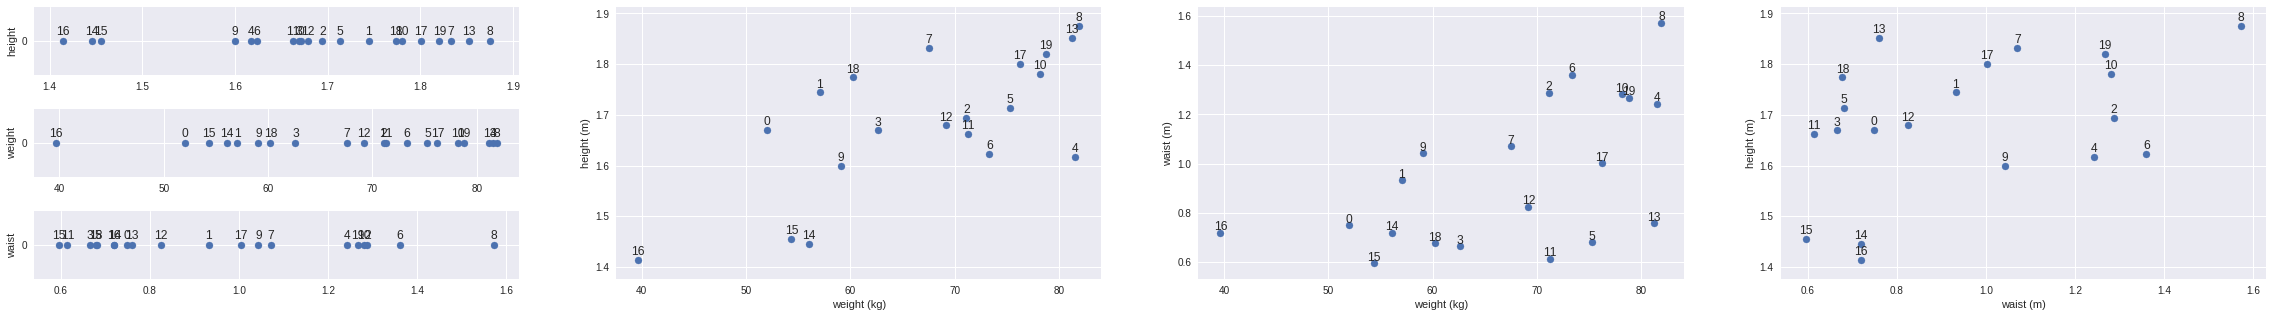

In [446]:
plt.figure(figsize=(40, 5))
plt.subplots_adjust(hspace=0.5)
ax1 = plt.subplot2grid((3, 4), (0, 0))
ax2 = plt.subplot2grid((3, 4), (1, 0))
ax3 = plt.subplot2grid((3, 4), (2, 0))
ax4 = plt.subplot2grid((3, 4), (0, 1), rowspan=3)
ax5 = plt.subplot2grid((3, 4), (0, 2), rowspan=3)
ax6 = plt.subplot2grid((3, 4), (0, 3), rowspan=3)

ax1.scatter(height, np.zeros(len(height)))
ax1.set_ylabel('height')
ax1.yaxis.set_ticks([0])
for i, _ in enumerate(height): ax1.annotate(i, (height[i], 0.01), horizontalalignment = 'center')
ax2.scatter(weight, np.zeros(len(height)))
ax2.set_ylabel('weight')
ax2.yaxis.set_ticks([0])
for i, _ in enumerate(height): ax2.annotate(i, (weight[i], 0.01), horizontalalignment = 'center')
ax3.scatter(waist, np.zeros(len(height)))
ax3.set_ylabel('waist')
ax3.yaxis.set_ticks([0])
for i, _ in enumerate(height): ax3.annotate(i, (waist[i], 0.01), horizontalalignment = 'center')

ax4.scatter(weight, height)
ax4.set_xlabel('weight (kg)')
ax4.set_ylabel('height (m)');
for i, _ in enumerate(height): ax4.annotate(i, (weight[i], height[i] + 0.01), horizontalalignment = 'center')
    
ax5.scatter(weight, waist)
ax5.set_xlabel('weight (kg)')
ax5.set_ylabel('waist (m)');
for i, _ in enumerate(height): ax5.annotate(i, (weight[i], waist[i] + 0.01), horizontalalignment = 'center')
    
ax6.scatter(waist, height)
ax6.set_xlabel('waist (m)')
ax6.set_ylabel('height (m)');
for i, _ in enumerate(height): ax6.annotate(i, (waist[i], height[i] + 0.01), horizontalalignment = 'center')

So the question is: how do we describe them or seperate them out as much as possible
- We can use height. Person 19, 7, 13, 8 are among the tallest, person 16 the shortest. What about those in the middle whose measurment are clustered together and it's harder to tell them apart.
- We can use weight. Person 16 is the lightest and so on. We again have people with similar measurement.
- The same goes for waist measurement.
- We can combine weight & height. In the scatter plot, we see that this combination can seperate out most people. Further, we can have a combination of weight vs waist, or waist vs height, or a combination of height, weight, waist.

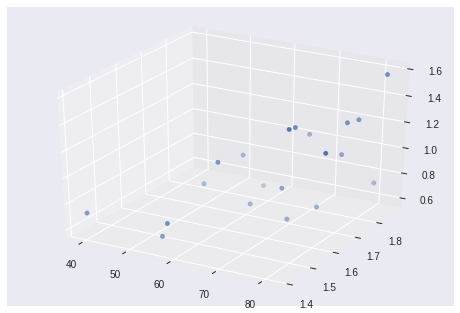

In [447]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.figure().add_subplot(111, projection='3d')
ax.scatter(weight, height, waist);

With only 20 people, using 2 characteristics, we can tell most of them apart.
For example:
- height 1.88, weight 81.9 can be mapped to person 8 
- height 1.41, weight 39.7 can be mapped to person 16

Etc. But imagine if we have 100+ people, their height and weight will have higher chances of overlapping, then it's harder to tell them apart. We can utilise the waist feature. But, eventually, the combination of height, weight, waist will not be sufficient to seperate the more people we have.

We can think of the forth feature: for example, the length of an arm. Then the fifth feature and so on, from hundreds of human anthropometric features. But it will be super hard for us to visualise the fourth dimension in a graph. This is when **PCA** comes in.

PCA seeks to maximise covariance between features and then reduce these features (dimensions) to managable dimensions so we can reason about them.

Let's check out some codes

In [448]:
# 1, variance
print('''Variance:
Height: {:.6f}
Weight: {:.6f}
Waist: {:.6f}
'''.format(np.cov(height), np.cov(weight), np.cov(waist))) # using np.cov instead of np.var because np.cov use df - 1

# and their covariance
print(np.cov([height, weight, waist]))

Variance:
Height: 0.017859
Weight: 137.394311
Waist: 0.087213

[[1.78586953e-02 1.07938164e+00 1.66807237e-02]
 [1.07938164e+00 1.37394311e+02 1.98616919e+00]
 [1.66807237e-02 1.98616919e+00 8.72131558e-02]]


We can see that the covariance are:
- Between height & weight: 1.079
- Between height & waist: 0.017
- Between weight & waist: 1.986

But since they are in different units (m vs kg), it is advised to normalise them to mean of 0 and std of 1

In [0]:
height_scaled = (height - height.mean()) / height.std(ddof = 1)
weight_scaled = (weight - weight.mean()) / weight.std(ddof = 1)
waist_scaled = (waist - waist.mean()) / waist.std(ddof = 1)

Now they are all scaled to mean of 0 and std of 1

In [450]:
np.cov([height_scaled, weight_scaled, waist_scaled]) # np.corrcoef([height, weight, waist]) # this gives the same result

array([[1.        , 0.68907388, 0.42266766],
       [0.68907388, 1.        , 0.573774  ],
       [0.42266766, 0.573774  , 1.        ]])

So the correlation 
- Between height & weight: 0.689
- Between height & waist: 0.423
- Between weight & waist: 0.574

We can see that:
- Height ranges from -2.0 to 1.4
- Weight ranges from -2.4 to 1.2

Can we project these points onto a line so their variances are maximised?



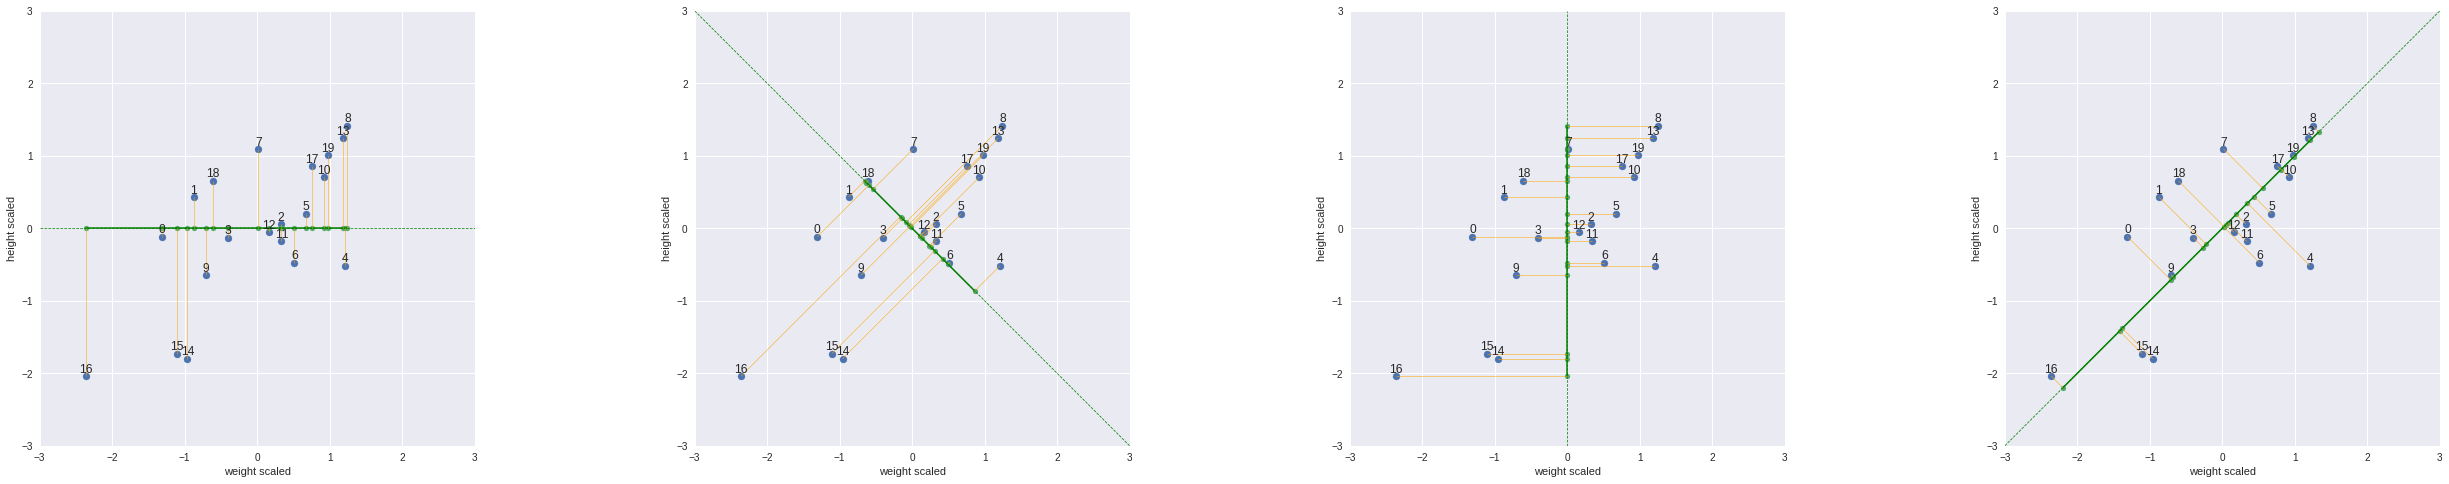

In [451]:
def main_plot(ax, *line):
    ax.scatter(weight_scaled, height_scaled)
    ax.set_xlabel('weight scaled')
    ax.set_ylabel('height scaled')
    ax.axis('square')
    ax.axis([-3, 3, -3, 3])
    
    # plot project line
    ax.plot(*line, ls='--', lw=0.75, color='green')
    
    # slope/coef of the line, and points on the line
    a = (line[1][1] - line[1][0]) / (line[0][1] - line[0][0]) if line[0][1] - line[0][0] != 0 else None
    w_online = -(-weight_scaled - a * height_scaled) / (a ** 2 + 1) if a is not None else np.zeros(len(height))
    h_online = a * (weight_scaled + a * height_scaled) / (a ** 2 + 1) if a is not None else height_scaled
    ax.scatter(w_online, h_online, s=25, lw=0.25)
    ys = [h_online.min(), h_online.max()] if a is not None and a >=0 else [h_online.max(), h_online.min()]
    ax.plot([w_online.min(), w_online.max()], ys, ls='-', lw=1.5, color='green')
    for i in range(0, len(height)):
        ax.plot([weight_scaled[i], w_online[i]], [height_scaled[i], h_online[i]], ls='-', lw=0.5, color='orange')
    for i, _ in enumerate(height): ax.annotate(i, (weight_scaled[i], height_scaled[i] + 0.05), horizontalalignment = 'center')


_, [ax0, ax1, ax2, ax3] = plt.subplots(1, 4, figsize=(45, 8))
main_plot(ax0, [-3, 3], [0, 0])
main_plot(ax1, [-3, 3], [3, -3])
main_plot(ax2, [0, 0], [-3, 3])
main_plot(ax3, [-3, 3], [-3, 3])

In the first plot, we project all the points onto the green line. This green line is parallel to the x axis, so the variance stays the same as the weight scaled.
In the second plot, we rotate the green line and again project all the points onto it. The variance actually gets smaller (as depicted by the solid green line)
In the third plot, we grren line is now parallel to the y axis and the variance is the same as height scaled.
In the last plot, we can see the variance has increased (the solid green portion)

So the green line in the last plot is our new axis where the variance is maximised.
Maximising variance is a similar task to minimising error (represented by the <span style="font-color: orange;">orange</span> line).


Now imagine 🤔 if we have waist as well, we need to find a plane to maximise these variance of height, weight and waist. If we add another feature, it will go to the 4th dimension, and our brains will have a difficult time to imagine.

So how do we find the green line in the last plot or a plane or higher dimensional spaces to maximising variance?
Luckily, other smart people have figured this out using matrix algebra.

In [452]:
A = np.array([height_scaled, weight_scaled])
M = np.cov(A) # create a matrix of correlation of height and weight as before
values, vectors = np.linalg.eig(M) # eigen decomposition
L = vectors * (np.sqrt(values)) # loadings
P = vectors.dot(-A) # projection / principle component

print('Correlation matrix\n', M)
print('\nEigen values\n', values)
print('\nEigen vectors\n', vectors)
print('\nLoading\n', L)
print('\nPrinciple components\n', P)

Correlation matrix
 [[1.         0.68907388]
 [0.68907388 1.        ]]

Eigen values
 [0.31092612 1.68907388]

Eigen vectors
 [[-0.70710678 -0.70710678]
 [ 0.70710678 -0.70710678]]

Loading
 [[-0.39428804 -0.91898691]
 [ 0.39428804 -0.91898691]]

Principle components
 [[-1.00617796 -0.31301773  0.2708533  -0.3740772   0.49103794  0.62103394
   0.0288365   0.7858034   1.88257074 -0.9558482   1.15360301  0.11082737
   0.0741066   1.7152323  -1.9513708  -2.00472739 -3.11006557  1.14425661
   0.03517759  1.40194555]
 [-0.8438274  -0.92677858  0.18678775 -0.1938753   1.22127155  0.33710947
   0.6955435  -0.76324432 -0.12084836 -0.04099587  0.15623931  0.36356045
   0.14894975 -0.03971746  0.59199032  0.43850089 -0.22766923 -0.07008735
  -0.89226882 -0.02064032]]


Because we started with 2 variables (features): height & weight, we will get 2 components back.

**Eigenvalue**: variance explained by a component:
- 0.3109: this component explains 0.3109 variance
- 1.6891: this component explains 1.6891 variance

Recall that initially, the variance of height and weight was each standardised to 1. So an eigen value > 1 indicates that this component explains more variance than using either height or weight alone.

Percentage wise, 1.6891 is 84.45%, 0.3109 is 15.55%. The componet explains the most variance will be our first principle component.

Eigenvalues correspondend to **eigenvectors**.
- \[-0.70710678, -0.70710678] has an eigenvalue of 0.3109
- \[0.70710678, -0.70710678] has an eigenvalue of 1.6891

The eigenvectors are the new projections / coordination system where the original data can project on.

For example, for person 0

| person | variable | inital value | scaled value | PC value |
| --- | --- | --- | --- | --- |
| 0 | height | 1.6709 | -0.1149 | 1.0062 |
| 0 | weight | 51.9967 | -1.3082 | 0.8438 |
| 1 | height | 1.7442 | 0.4340 | 0.3130 |
| 1 | weight | 57.0543 | -0.8767 | 0.9268 |
| 4 | height | 1.6172 | -0.5164 | -0.4910 |
| 4 | weight | 81.8225 | 1.2108 | -1.2213 |

Looking at at PC values, we can see that person 0 and 4 are quite different apart, while person 0 and 1 are more close together.

- PC1 is a linear combination of -0.7071 × height + -0.7071 × weight
- PC2 is a linear combination of 0.7071 × height + -0.7071 × weight


The result can be visualised by the plot below, known as biplot.

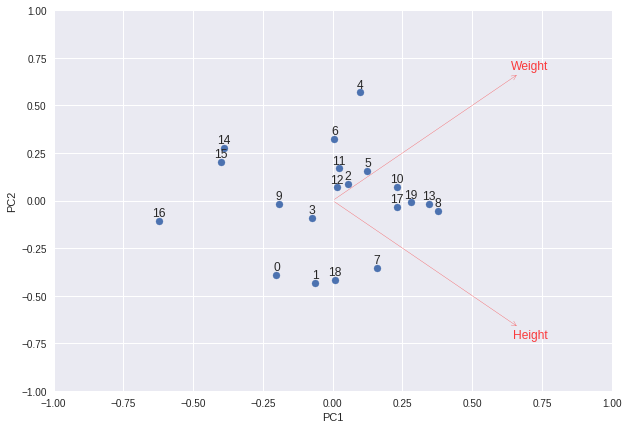

In [453]:
plt.figure(figsize=(10,7))
def biplot(PC, coef, varname):
    P_scaled = np.transpose(np.multiply(PC.T, 1 / (PC.max(axis = 1) - PC.min(axis = 1))))
    plt.scatter(P_scaled[0], P_scaled[1]);
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    # plt.axis('square')
    plt.axis([-1, 1, -1, 1])
    for i in range(len(PC[0])): plt.annotate(i, (P_scaled[0][i], P_scaled[1][i] + 0.025), horizontalalignment = 'center')
    for i, p in enumerate(-coef.T):
        plt.annotate(varname[i], xy=(0,0), xytext=p, arrowprops={ 'arrowstyle': '<-', 'color': 'red', 'alpha': 0.75 }, color = 'red', alpha=0.75, ha='center', va='center')

biplot(P, vectors, ['Height', 'Weight'])

In [454]:
pd.DataFrame({ 'height': height, 'weight': weight, 'height_scaled': height_scaled, 'weight_scaled': weight_scaled, 'PC1': P[0], 'PC2': P[1] }, )

,PC1,PC2,height,height_scaled,weight,weight_scaled
0,-1.006178,-0.843827,1.670907,-0.114799,51.996660,-1.308151
1,-0.313018,-0.926779,1.744246,0.433994,57.054302,-0.876668
2,0.270853,0.186788,1.694193,0.059443,71.123298,0.323601
3,-0.374077,-0.193875,1.669220,-0.127422,62.622795,-0.401603
4,0.491038,1.221272,1.617245,-0.516353,81.522461,1.210786
5,0.621034,0.337109,1.713078,0.200765,75.271650,0.677510
6,0.028836,0.695544,1.623248,-0.471433,73.334131,0.512214
7,0.785803,-0.763244,1.832626,1.095342,67.517176,0.015952
8,1.882571,-0.120848,1.875562,1.416631,81.932013,1.245726
9,-0.955848,-0.040996,1.599800,-0.646898,59.067981,-0.704875


We see that person 4 and 8 have similar weights (~81 kg), but since person 8 is taller, so the PC1 seperates them out.

Similarly, person 10 and 18 have similar height (~1.78 m) but differ quite a bit in weight, so again PC1 seperates them out.

So far we have only used 2 features: height & weight. We will now include waist.

In [455]:
A = np.transpose(np.array([height_scaled, weight_scaled]))

from sklearn.decomposition import PCA # this class perform PCA, so we don't need to do things "manually" with numpy
pca = PCA()
pca.fit(A)

print('The results below are the same as we did manually')
print(pca.explained_variance_) # eigenvalues, in R, it is stored in sdev ** 2
print(pca.components_) # eigenvectors, in R, it is stored in Rotation
print(pca.transform(A).T) # the PC, in R, it is stored in x
# the above results are the same as we did manually


# now we include waist
A = np.transpose(np.array([height_scaled, weight_scaled, waist_scaled]))
pca.fit(A)
print('\nNow we include waist')
print('Eigenvalues\n', pca.explained_variance_)
print('\nEigenvectors\n', pca.components_)
L = pca.components_ * (np.sqrt(pca.explained_variance_)) # the loading
P = pca.transform(A).T
print('\nLoading\n', L)
print('\nPCs\n', P)

The results below are the same as we did manually
[1.68907388 0.31092612]
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
[[ 1.00617796  0.31301773 -0.2708533   0.3740772  -0.49103794 -0.62103394
  -0.0288365  -0.7858034  -1.88257074  0.9558482  -1.15360301 -0.11082737
  -0.0741066  -1.7152323   1.9513708   2.00472739  3.11006557 -1.14425661
  -0.03517759 -1.40194555]
 [-0.8438274  -0.92677858  0.18678775 -0.1938753   1.22127155  0.33710947
   0.6955435  -0.76324432 -0.12084836 -0.04099587  0.15623931  0.36356045
   0.14894975 -0.03971746  0.59199032  0.43850089 -0.22766923 -0.07008735
  -0.89226882 -0.02064032]]

Now we include waist
Eigenvalues
 [2.1306183  0.58949417 0.27988754]

Eigenvectors
 [[-0.5768478  -0.62092159 -0.530757  ]
 [ 0.58034482  0.14572808 -0.80122607]
 [-0.57484477  0.77020757 -0.27628571]]

Loading
 [[-0.84200382 -0.47673443 -0.2807938 ]
 [ 0.84710831  0.11188787 -0.42388383]
 [-0.83908008  0.591354   -0.14616729]]

PCs
 [[ 1.24616792e+00  3.32774196e-01 -

Now our PC1 explains 2.131 variances and is composed of -0.577 × height + -0.621 × weight + -0.531 × waist

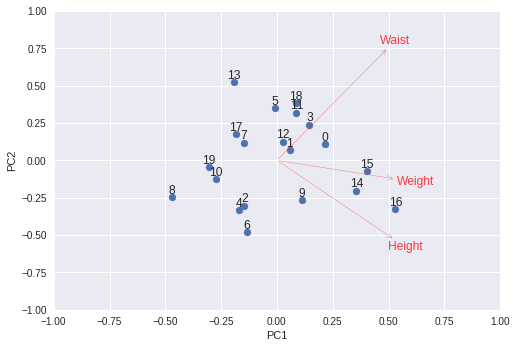

In [456]:
biplot(P, pca.components_[:2], ['Height', 'Weight', 'Waist'])

**Data compression**

Now we have 3 components, with component 1 explaining 71.0%, component 2 explaining 19.6% , component 3 explaining the remaining 9.4%.

Say if we can afford to lose 9.4% of the data, we can just keep component 1 and 2.

True


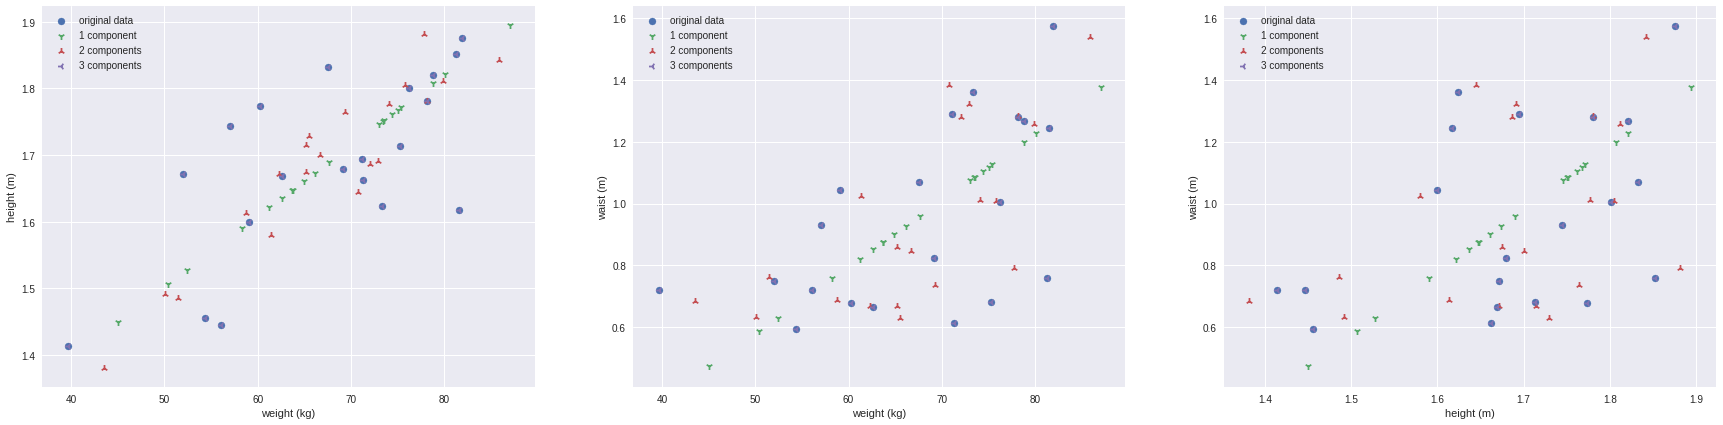

In [457]:
A = [None] * 4
A[0] = np.array([height, weight, waist]).T # original data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pca = PCA()
P = pca.fit_transform(scaler.fit_transform(A[0]))

A[3] = scaler.inverse_transform(np.dot(P, pca.components_)) # get back the original data using all 3 components
print(np.allclose(A[0], A[3])) # and they are close

A[2] = scaler.inverse_transform(np.dot(P[:,:2], pca.components_[:2])) # using 2 components
A[1] = scaler.inverse_transform(np.dot(P[:,:1], pca.components_[:1])) # using 1 component

_, axs = plt.subplots(1, 3, figsize=(30, 7))
labels = ['original data', '1 component', '2 components', '3 components']
for i in range(4):
    marker=str(i) if i else 'o'
    axs[0].scatter(A[i].T[1], A[i].T[0], marker=marker, label=labels[i])
    axs[0].set_xlabel('weight (kg)')
    axs[0].set_ylabel('height (m)')
    axs[1].scatter(A[i].T[1], A[i].T[2], marker=marker, label=labels[i])
    axs[1].set_xlabel('weight (kg)')
    axs[1].set_ylabel('waist (m)')
    axs[2].scatter(A[i].T[0], A[i].T[2], marker=marker, label=labels[i])
    axs[2].set_xlabel('height (m)')
    axs[2].set_ylabel('waist (m)')
for i in range(3): axs[i].legend()

We can see that when we use all 3 components, the original data are restored faithfully.

When we use only 2 components, we loose some fidelity (red marker)

When we only use 1 component, we end up in a straight line (green marker)


In [0]:
# data = pd.read_csv('data_nutrition.csv')
# data_sub = data[data.Shrt_Desc.str.contains(r'(?i)apple|banana|cherr|melon|peanut|broco|potato|coconut|orange|tomato|walnut|almond|avocado|cucumber|kiwi|carrot', regex=True)]
# data_sub